In [44]:
function kilo2coord(x, y)
    deg2kilo = 105.6
    ref_coord = [17.992 -67.155]
    lat = ref_coord[1] + (x / deg2kilo);
    lng = ref_coord[2] + (y / deg2kilo);
    return lat, lng
end

using PyPlot

function draw_route(carrier_coords, route_coords, drone_route)
    num_drones = size(drone_route)[1]
    num_carriers = size(carrier_coords)[1]
    num_routes = size(route_coords)[1]
    
    all_coords = vcat(carrier_coords, route_coords)
    
    carrier_range = 1: num_carriers
    route_range = num_carriers + 1: num_carriers + num_routes
    
    for i in 1: num_carriers
        plot(carrier_coords[i, 1], carrier_coords[i, 2], "ro")
    end
    for i in 1: num_drones
        carrier_idx = 0
        route_idx = 0
        for j in carrier_range
            for k in route_range
                if drone_route[i, j, k] == 1
                    carrier_idx = j
                    route_idx = k
                end
            end
        end
        if carrier_idx == 0 || route_idx == 0
            println("Invalid route: No starting point")
            return
        end
        println("Drone $i: $carrier_idx to $route_idx")
        plot([all_coords[carrier_idx, 1], all_coords[route_idx, 1]], 
            [all_coords[carrier_idx, 2], all_coords[route_idx, 2]], "b-")
        while route_idx > num_carriers
            next_idx = 0
            for k in 1: num_carriers + num_routes
                if drone_route[i, route_idx, k] == 1
                    next_idx = k
                end
            end
            if next_idx == 0
                println("Invalid route: Broken path")
                return
            end
            println("Drone $i: $route_idx to $next_idx")
            plot([all_coords[route_idx, 1], all_coords[next_idx, 1]], 
                [all_coords[route_idx, 2], all_coords[next_idx, 2]], "b-")
            route_idx = next_idx
        end
    end
end

function draw_all(carrier_coords, route_coords, drone_route)
    num_drones = size(drone_route)[1]
    num_carriers = size(carrier_coords)[1]
    num_routes = size(route_coords)[1]
    
    all_coords = vcat(carrier_coords, route_coords)
    
    for i in 1: num_carriers
        plot(carrier_coords[i, 1], carrier_coords[i, 2], "ro")
    end
    
    for k in 1: num_drones
        for i in 1: (num_carriers + num_routes)
            for j in 1: (num_carriers + num_routes)
                if drone_route[k, i, j] > 0
                    plot([all_coords[i, 1], all_coords[j, 1]], [all_coords[i, 2], all_coords[j, 2]], "b-")
                    println("Drone $k: $i to $j")
                end
            end
        end
    end
end

draw_all (generic function with 1 method)

In [ ]:
using JuMP, Gurobi

drone_capacity = [3.5 8 14 11 15 22 20]
drone_speed = [40 79 64 60 60 79 64]
drone_flight_time = [35 40 35 18 15 24 16]

med_package_weight = [2 2 3]
med_package_comp_spec = [2 0 0; 0 4 0; 0 0 2; 1 2 0; 1 0 1; 0 2 1]
dest_coord=[18.33 -65.65; 18.22 -66.03; 18.44 -66.07; 18.40 -66.16; 18.47 -66.73]
demand = [1 0 1; 2 0 1; 1 1 0; 2 1 2; 1 0 0]


R = 6371 # radius of the earth in kilometers

# haversine_distance between two coordinates
function haversine_dist(lat1, lng1, lat2, lng2)
    ϕ1 = deg2rad(lat1)
    ϕ2 = deg2rad(lat2)
    Δϕ = deg2rad(lat1 - lat2)
    Δλ = deg2rad(lng1 - lng2)
    
    a = sin(Δϕ / 2) ^ 2 + cos(ϕ1) * cos(ϕ2) * (sin(Δλ / 2) ^ 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c
end

m = Model(solver = IpoptSolver())

JuMP.register(m, :haversine_dist, 4, haversine_dist, autodiff=true)

drone_max_num = 10
@variable(m, carrier_coord[1:3, 1:2])
@variable(m, drone_comp[1:drone_max_num, 1:3])
@variable(m, drone_dest[1:drone_max_num, 1:5])
@variable(m, drone_pkg_comp[1:drone_max_num, 1:6])
for drone in 1: drone_max_num
    @constraint(m, sum(drone_comp[drone, :]) <= 1)
    @constraint(m, sum(drone_dest[drone, :]) <= 1)
    @constraint(m, sum(drone_pkg_comp[drone, :]) <= 1)
    @constraint(m, sum(drone_pkg_comp[drone, :]) == sum(drone_comp[drone, :]))
    @constraint(m, sum(drone_dest[drone, :]) == sum(drone_comp[drone, :]))
end
for dest_cnt in 1: size(dest_coord)[1]
    @constraint(m, sum(sum(drone_dest[:, dest_cnt] .* drone_pkg_comp, 1)' .* med_package_comp_spec, 1)' .>= demand[dest_cnt, :])
end

# Quadratic
distance_mat = Array{JuMP.GenericQuadExpr{Float64, JuMP.Variable}, 2}(size(carrier_coord)[1], size(dest_coord)[1])
for i = 1:size(carrier_coord)[1]
    for j = 1:size(dest_coord)[1]
        distance_mat[i, j] = (carrier_coord[i, 1] - dest_coord[j, 1]) ^ 2 + (carrier_coord[i, 2] - dest_coord[j, 2]) ^ 2
    end
end
# @expression(m, distance_mat[i = 1:size(carrier_coord)[1], j = 1:size(dest_coord)[1]], 
#     (carrier_coord[i, 1] - dest_coord[j, 1]) ^ 2 + (carrier_coord[i, 2] - dest_coord[j, 2]) ^ 2)
@expression(m, drone_travel_dist[i = 1:drone_max_num], 
    sum((drone_comp[i, a] * drone_dest[i, b]) * distance_mat[a, b] for a = 1: size(drone_comp)[2], b = 1: size(drone_dest)[2]))
@objective(m, Min, sum(drone_travel_dist))

# Nonlinear
# @NLexpression(m, distance_mat[i = 1: size(carrier_coord)[1], j= 1: size(dest_coord)[1]],
#     haversine_dist(carrier_coord[i, 1], carrier_coord[i, 2], dest_coord[j, 1], dest_coord[j, 2]))
# @NLexpression(m, drone_travel_dist[i = 1:drone_max_num], 
#     sum((drone_comp[i, a] * drone_dest[i, b]) * distance_mat[a, b] for a = 1: size(drone_comp)[2], b = 1: size(drone_dest)[2]))
# @NLobjective(m, Min, sum(drone_travel_dist[i] for i = 1:drone_max_num))
#

status = solve(m)


In [2]:
using JuMP, AmplNLWriter

function haversine_dist(lat1, lng1, lat2, lng2)
    ϕ1 = deg2rad(lat1)
    ϕ2 = deg2rad(lat2)
    Δϕ = deg2rad(lat1 - lat2)
    Δλ = deg2rad(lng1 - lng2)
    
    a = sin(Δϕ / 2) ^ 2 + cos(ϕ1) * cos(ϕ2) * (sin(Δλ / 2) ^ 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c
end

# dest_coord=[18.33 -65.65; 18.22 -66.03; 18.44 -66.07; 18.40 -66.16; 18.47 -66.73]
# route_coord=[18.090 -67.023; 18.147 -67.144; 18.279 -67.165; 18.358 -67.264; 18.405 -67.152; 18.442 -67.145; 18.472 -66.936;
# 18.341 -66.989; 17.970 -66.935; 18.011 -66.888; 18.152 -66.884; 18.185 -66.856; 18.297 -66.871; 18.468 -66.726;
# 18.268 -66.711; 18.180 -66.736; 17.993 -66.637; 18.441 -66.543; 18.234 -66.523; 18.131 -66.495; 18.440 -66.420;
# 18.230 -66.389; 17.972 -66.407; 18.420 -66.164; 18.172 -66.368; 18.129 -66.286; 18.388 -66.159; 18.243 -66.210;
# 18.100 -66.163; 17.976 -66.125; 18.248 -66.041; 17.992 -66.011; 18.184 -65.968; 18.324 -65.656; 18.216 -65.730;
# 18.125 -65.817; 18.002 -65.895]
dest_coord=[35.6928 158.928; 24.0768 118.8; 47.3088 114.576; 43.0848 105.072; 50.4768 44.88;]
route_coord = readcsv("route.csv")
dist_matrix = readcsv("distmat.csv")

m = Model(solver=AmplNLSolver("D:\\Googledrive\\MCM\\bonmin-win64\\bonmin"))
# m = Model(solver=IpoptSolver(hessian_approximation="limited-memory"))

JuMP.register(m, :haversine_dist, 4, haversine_dist, autodiff=true)

M = 10000
EPS = 1e-5
# deg2kilo = 105
max_flight_range = 32

carrier_cnt = 3
dest_cnt = size(dest_coord)[1]
route_cnt = size(route_coord)[1]
@variable(m, carrier_coord[1:carrier_cnt, 1:2])
setvalue(carrier_coord, [18.2 -65.0; 18.1 -66.0; 18.5 -67.0] + (randn() / 10))
@variable(m, cd_carrier_assignment[1:carrier_cnt, 1:dest_cnt], Bin)
# setvalue(cd_carrier_assignment, zeros(size(cd_carrier_assignment)))
@variable(m, cr_carrier_assignment[1:carrier_cnt, 1:route_cnt], Bin)
# @variable(m, drone_route[1:route_cnt + carrier_cnt, 1:route_cnt + carrier_cnt], Bin)

@NLexpression(m, cd_distance_mat[a=1:carrier_cnt, b=1:dest_cnt], 
    sqrt(((carrier_coord[a, 1] - dest_coord[b, 1])) ^ 2 + ((carrier_coord[a, 2] - dest_coord[b, 2])) ^ 2 + EPS))
@NLexpression(m, cr_distance_mat[a=1:carrier_cnt, b=1:route_cnt], 
    sqrt(((carrier_coord[a, 1] - route_coord[b, 1])) ^ 2 + ((carrier_coord[a, 2] - route_coord[b, 2])) ^ 2 + EPS))

# all carriers are at least assigned to one of the destinations
for i in 1: carrier_cnt
    @constraint(m, sum(cd_carrier_assignment[i, :]) >= 1)
end

# all destinations must be assigned at least one carrier
for i in 1: dest_cnt
    @constraint(m, sum(cd_carrier_assignment[:, i]) >= 1)
    # destination be within the maximum flight range (drone B)
    for j in 1: carrier_cnt
        M = 300
        @NLconstraint(m, cd_distance_mat[j, i] - max_flight_range <= M * (-cd_carrier_assignment[j, i] + 1))
    end
end

# all route points be within the maximum flight range
for i in 1: route_cnt
    for j in 1: carrier_cnt
        M = 300
        @NLconstraint(m, cr_distance_mat[j, i] - max_flight_range <= M * (-cr_carrier_assignment[j, i] + 1))
    end
end

# for i in 1: carrier_cnt
#     @constraint(m, sum(drone_route[i, 1: carrier_cnt]) == 0)
#     @constraint(m, )
#     @constraint(m, sum(drone_route[i, carrier_cnt + 1: carrier_cnt + route_cnt]) == carrier_num_drones[i])
#     @constraint(m, sum(drone_route[carrier_cnt + 1: carrier_cnt + route_cnt, i]) == carrier_num_drones[i])
# end

# for i in carrier_cnt + 1: carrier_cnt + route_cnt
#     @constraint(m, sum(drone_route[i, :]) == 1)
#     @constraint(m, sum(drone_route[:, i]) == 1)
# end
        

@NLobjective(m, Min, sum(cd_distance_mat[a, b] * cd_carrier_assignment[a, b] for a = 1: carrier_cnt, b = 1: dest_cnt) + 
    sum(cr_distance_mat[a, b] * cr_carrier_assignment[a, b] for a = 1: carrier_cnt, b = 1: route_cnt))


status = solve(m)
result = getvalue(carrier_coord)
carrier_coord_kilo = getvalue(carrier_coord)
carrier_coord_latlng = Array{Float64, 2}(size(carrier_coord))
for i in 1: carrier_cnt
    carrier_coord_latlng[i, 1], carrier_coord_latlng[i, 2] = kilo2coord(carrier_coord_kilo[i, 1], carrier_coord_kilo[i, 2])
end
println("Carrier coordinates: ", carrier_coord_latlng)
println("Assignments: ", getvalue(cd_carrier_assignment))

Bonmin 1.8.6 using Cbc 2.9.9 and Ipopt 3.12.8
bonmin: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 80.635436      290 2.795
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 31.960462      241 2.074
NLP0014I             2         OPT 31.960734      391 1.688
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 31.960734        6 0.022
Cbc0012I Integer 

In [ ]:
using JuMP, Gurobi

dest_coord=[35.6928 158.928; 24.0768 118.8; 47.3088 114.576; 43.0848 105.072; 50.4768 44.88;]
route_coord = readcsv("route.csv")
route_distance_mat = readcsv("distmat.csv")

# m = Model(solver=AmplNLSolver("/mnt/d/googledrive/MCM/bonmin-linux64/bonmin"))
m = Model(sovler=GurobiSolver())
# m = Model(solver=IpoptSolver(hessian_approximation="limited-memory"))

JuMP.register(m, :haversine_dist, 4, haversine_dist, autodiff=true)

M = 10000
EPS = 1e-5
# deg2kilo = 105
max_flight_range = 32

# @variable(m, carrier_coord[1:carrier_cnt, 1:2])
carrier_coord = result
@variable(m, carrier_num_drones[1: carrier_cnt], Int)
# setvalue(carrier_coord, [18.2 -65.0; 18.1 -66.0; 18.5 -67.0] + (randn() / 100))
@variable(m, drone_route[1:route_cnt + carrier_cnt, 1:route_cnt + carrier_cnt], Bin)
@variable(m, u[1: carrier_cnt + route_cnt], Bin)
@variable(m, cd_carrier_assignment[1:carrier_cnt, 1:dest_cnt], Bin)

cd_distance_mat = Array{Float64, 2}(carrier_cnt, dest_cnt)
cr_distance_mat = Array{Float64, 2}(carrier_cnt, route_cnt)

for a = 1: carrier_cnt
    for b = 1: dest_cnt
        cd_distance_mat[a, b] = sqrt(((carrier_coord[a, 1] - dest_coord[b, 1])) ^ 2 + ((carrier_coord[a, 2] - dest_coord[b, 2])) ^ 2)
    end
    for b = 1: route_cnt
        cr_distance_mat[a, b] = sqrt(((carrier_coord[a, 1] - route_coord[b, 1])) ^ 2 + ((carrier_coord[a, 2] - route_coord[b, 2])) ^ 2)
    end
end

# @NLexpression(m, cd_distance_mat[a=1:carrier_cnt, b=1:dest_cnt], 
#     sqrt(((carrier_coord[a, 1] - dest_coord[b, 1])) ^ 2 + ((carrier_coord[a, 2] - dest_coord[b, 2])) ^ 2 + EPS))
# @NLexpression(m, cr_distance_mat[a=1:carrier_cnt, b=1:route_cnt], 
#     sqrt(((carrier_coord[a, 1] - route_coord[b, 1])) ^ 2 + ((carrier_coord[a, 2] - route_coord[b, 2])) ^ 2 + EPS))

# all carriers are at least assigned to one of the destinations
for i in 1: carrier_cnt
    @constraint(m, sum(cd_carrier_assignment[i, :]) >= 1)
end

# all destinations must be assigned at least one carrier
for i in 1: dest_cnt
    @constraint(m, sum(cd_carrier_assignment[:, i]) >= 1)
    # destination be within the maximum flight range (drone B)
    for j in 1: carrier_cnt
        M = 300
        @constraint(m, cd_distance_mat[j, i] - max_flight_range <= M * (-cd_carrier_assignment[j, i] + 1))
    end
end

for i in 1: carrier_cnt
    @constraint(m, sum(drone_route[i, 1: carrier_cnt]) == 0)
    @constraint(m, sum(drone_route[i, carrier_cnt + 1: carrier_cnt + route_cnt]) == carrier_num_drones[i])
    @constraint(m, sum(drone_route[carrier_cnt + 1: carrier_cnt + route_cnt, i]) == carrier_num_drones[i])
end

for i in carrier_cnt + 1: carrier_cnt + route_cnt
    @constraint(m, sum(drone_route[i, :]) == 1)
    @constraint(m, sum(drone_route[:, i]) == 1)
end

max_stops = 50
# Miller-Tucker-Zemlin subtour elimination
for i in 1: carrier_cnt + route_cnt
    for j in 1: carrier_cnt + route_cnt
        @constraint(m, u[i] - u[j] + max_stops * drone_route[i, j] <= max_stops - 1)
    end
end

@expression(m, dist_depot_to_route, sum((drone_route[i, j + carrier_cnt] + drone_route[j + carrier_cnt, i]) * cr_distance_mat[i, j]
    for i = 1: carrier_cnt, j = 1: route_cnt))
@expression(m, dist_route_to_route, 
    sum((drone_route[i + carrier_cnt, j + carrier_cnt] + drone_route[j + carrier_cnt, i + carrier_cnt]) * route_distance_mat[i, j]
    for i = 1: route_cnt, j = 1: route_cnt))

@objective(m, Min, dist_depot_to_route + dist_route_to_route)

status = solve(m)

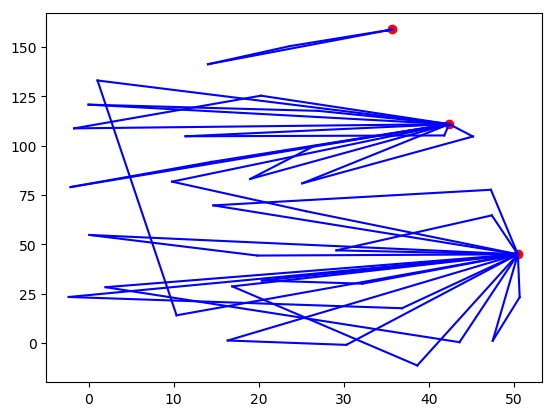

Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 4683 rows, 5172 columns and 45786 nonzeros
Variable types: 0 continuous, 5172 integer (5172 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [5e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 263 rows and 156 columns
Presolve time: 0.06s
Presolved: 4420 rows, 5016 columns, 36138 nonzeros
Variable types: 0 continuous, 5016 integer (5016 binary)
Found heuristic solution: objective 2550.7063906

Root relaxation: objective 4.113048e+02, 135 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  411.30485    0   76 2550.70639  411.30485  83.9%     -    0s
H    0     0                    1527.5645397  411.30485  73.1%     -    0s


In [55]:
using JuMP, Gurobi

dest_coord=[35.6928 158.928; 24.0768 118.8; 47.3088 114.576; 43.0848 105.072; 50.4768 44.88;]
route_coord = readcsv("route2.csv")
route_distance_mat = readcsv("distmat.csv")

# m = Model(solver=AmplNLSolver("/mnt/d/googledrive/MCM/bonmin-linux64/bonmin"))
m = Model(solver=GurobiSolver())
# m = Model(solver=IpoptSolver(hessian_approximation="limited-memory"))

# JuMP.register(m, :haversine_dist, 4, haversine_dist, autodiff=true)

carrier_cnt = 3
route_cnt = size(route_coord)[1]

M = 2000
EPS = 1e-5
# deg2kilo = 105
max_flight_range = 32
max_drones = 3

# @variable(m, carrier_coord[1:carrier_cnt, 1:2])
carrier_coord = result
# setvalue(carrier_coord, [18.2 -65.0; 18.1 -66.0; 18.5 -67.0] + (randn() / 100))
@variable(m, drone_route[1: max_drones, 1:route_cnt + carrier_cnt, 1:route_cnt + carrier_cnt], Bin)
@variable(m, cd_carrier_assignment[1:carrier_cnt, 1:dest_cnt], Bin)
@variable(m, u[1: max_drones, 1: route_cnt], Bin)

cd_distance_mat = Array{Float64, 2}(carrier_cnt, dest_cnt)
cr_distance_mat = Array{Float64, 2}(carrier_cnt, route_cnt)

for a = 1: carrier_cnt
    for b = 1: dest_cnt
        cd_distance_mat[a, b] = sqrt(((carrier_coord[a, 1] - dest_coord[b, 1])) ^ 2 + ((carrier_coord[a, 2] - dest_coord[b, 2])) ^ 2)
    end
    for b = 1: route_cnt
        cr_distance_mat[a, b] = sqrt(((carrier_coord[a, 1] - route_coord[b, 1])) ^ 2 + ((carrier_coord[a, 2] - route_coord[b, 2])) ^ 2)
    end
end

# @NLexpression(m, cd_distance_mat[a=1:carrier_cnt, b=1:dest_cnt], 
#     sqrt(((carrier_coord[a, 1] - dest_coord[b, 1])) ^ 2 + ((carrier_coord[a, 2] - dest_coord[b, 2])) ^ 2 + EPS))
# @NLexpression(m, cr_distance_mat[a=1:carrier_cnt, b=1:route_cnt], 
#     sqrt(((carrier_coord[a, 1] - route_coord[b, 1])) ^ 2 + ((carrier_coord[a, 2] - route_coord[b, 2])) ^ 2 + EPS))

# all carriers are at least assigned to one of the destinations
for i in 1: carrier_cnt
    @constraint(m, sum(cd_carrier_assignment[i, :]) >= 1)
end

# all destinations must be assigned at least one carrier
for i in 1: dest_cnt
    @constraint(m, sum(cd_carrier_assignment[:, i]) >= 1)
    # destination be within the maximum flight range (drone B)
    for j in 1: carrier_cnt
        M = 300
        @constraint(m, cd_distance_mat[j, i] - max_flight_range <= M * (-cd_carrier_assignment[j, i] + 1))
    end
end

carrier_range = 1: carrier_cnt
route_range = carrier_cnt + 1: carrier_cnt + route_cnt
# for k in 1: max_drones
#     for d in carrier_range
#         @constraint(m, sum(drone_route[k, d, carrier_range]) == 0)
#     end
#     for i in route_range
#         @constraint(m, drone_route[k, i, i] == 0)
#         @constraint(m, sum(drone_route[k, carrier_range, i]) + sum(drone_route[k, route_range, i])
#             - sum(drone_route[k, i, route_range]) - sum(drone_route[k, i, carrier_range]) == 0)
#     end
#     @constraint(m, sum(drone_route[k, route_range, carrier_range]) - sum(drone_route[k, route_range, carrier_range]) == 0)
#     @constraint(m, sum(drone_route[k, route_range, route_range]) <= M * sum(drone_route[k, carrier_range, route_range]))
    
# end

# for i in 1: route_cnt
#     @constraint(m, sum(drone_route[:, carrier_range, i]) + sum(drone_route[:, route_range, i]) == 1)
#     @constraint(m, sum(drone_route[:, i, carrier_range]) + sum(drone_route[:, i, route_range]) == 1)
# end

for k in 1: max_drones
    for d in carrier_range
        @constraint(m, sum(drone_route[k, d, carrier_range]) == 0)
        @constraint(m, sum(drone_route[k, d, route_range]) == sum(drone_route[k, route_range, d]))
    end
#     @constraint(m, sum(drone_route[k, carrier_range, route_range]) == 1)
#     @constraint(m, sum(drone_route[k, route_range, carrier_range]) == 1)
    for i in route_range
        @constraint(m, drone_route[k, i, i] == 0)
        @constraint(m, sum(drone_route[k, :, i]) - sum(drone_route[k, i, :]) == 0)
    end
    @constraint(m, sum(drone_route[k, route_range, carrier_range]) - sum(drone_route[k, route_range, carrier_range]) == 0)
    @constraint(m, sum(drone_route[k, route_range, route_range]) <= M * sum(drone_route[k, carrier_range, route_range]))
end

for i in route_range
    for k in 1: max_drones
        @constraint(m, sum(drone_route[k, :, i]) == sum(drone_route[k, i, :]))
    end
    @constraint(m, sum(drone_route[:, :, i]) == 1)
    @constraint(m, sum(drone_route[:, i, :]) == 1)
end

max_stops = 100
# Miller-Tucker-Zemlin subtour elimination
for k in 1: max_drones
    for i in 1 : route_cnt
        for j in 1 : route_cnt
            if i != j 
                @constraint(m, u[k, i] - u[k, j] + max_stops * drone_route[k, i + carrier_cnt, j + carrier_cnt] <= max_stops - 1)
            end
        end
    end
end

@expression(m, dist_depot_to_route, sum(sum(drone_route[k, carrier_range, route_range] .* cr_distance_mat) for k in 1: max_drones))
@expression(m, dist_route_to_depot, sum(sum(drone_route[k, route_range, carrier_range]' .* cr_distance_mat) for k in 1: max_drones))
@expression(m, dist_route_to_route, sum(drone_route[k, i, j] * route_distance_mat[i, j] for k in 1: max_drones, i in route_range, j in route_range))

@objective(m, Min, dist_depot_to_route + dist_route_to_depot + dist_route_to_route)

status = solve(m)

# if status == "Optimal"
draw_all(carrier_coord, route_coord, getvalue(drone_route))

In [56]:
print(result)

[35.6928 158.928; 42.3975 110.914; 50.4768 44.88]